<a href="https://colab.research.google.com/github/TomohiroYazaki/UW-Madison_GI_Tract_Image_Segmentation/blob/main/EDA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
import gc
from IPython import display as ipd
from joblib import Parallel, delayed

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

#import tensorflow as tf

In [2]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = np.asarray(mask_rle.split(), dtype=int)
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [3]:
def get_metadata(row):
    data = row['id'].split('_')
    case = int(data[0].replace('case',''))
    day = int(data[1].replace('day',''))
    slice_ = int(data[-1])
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
    return row

def path2info(row):
    path = row['image_path']
    data = path.split('/')
    slice_ = int(data[-1].split('_')[1])
    case = int(data[-3].split('_')[0].replace('case',''))
    day = int(data[-3].split('_')[1].replace('day',''))
    width = int(data[-1].split('_')[2])
    height = int(data[-1].split('_')[3])
    row['height'] = height
    row['width'] = width
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
    return row

In [16]:
def id2mask(df,id_):
    idf = df[df['id']==id_]
    wh = idf[['height','width']].iloc[0]
    shape = (wh.height, wh.width, 3)
    mask = np.zeros(shape, dtype=np.uint8)
    for i, class_ in enumerate(['large_bowel', 'small_bowel', 'stomach']):
        cdf = idf[idf['class']==class_]
        rle = cdf.segmentation.squeeze()
        if len(cdf) and not pd.isna(rle):
            mask[..., i] = rle_decode(rle, shape[:2])
    return mask

def rgb2gray(mask):
    pad_mask = np.pad(mask, pad_width=[(0,0),(0,0),(1,0)])
    gray_mask = pad_mask.argmax(-1)
    return gray_mask

#def gray2rgb(mask):
#    rgb_mask = tf.keras.utils.to_categorical(mask, num_classes=4)
#    return rgb_mask[..., 1:].astype(mask.dtype)

In [19]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = img.astype('float32') # original is uint16
    img = (img - img.min())/(img.max() - img.min())*255.0 # scale image to [0, 255]
    img = img.astype('uint8')
    return img

def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = [ "Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

In [ ]:
#df = pd.read_csv('/content/drive/MyDrive/Kaggle/UW-Madison_GI_Tract_Image_Segmentation/Data/train.csv')
## df = df[~df.segmentation.isna()]
#df = df.progress_apply(get_metadata, axis=1)
#df.head()

In [ ]:
#paths = glob('/content/drive/MyDrive/Kaggle/UW-Madison_GI_Tract_Image_Segmentation/Data/train/*/*/*/*')
#path_df = pd.DataFrame(paths, columns=['image_path'])
#path_df = path_df.progress_apply(path2info, axis=1)
#df = df.merge(path_df, on=['case','day','slice'])
#df.head()

In [11]:
#df.to_csv("/content/drive/MyDrive/Kaggle/UW-Madison_GI_Tract_Image_Segmentation/Data/train_df.csv")

In [12]:
train_df = pd.read_csv('/content/drive/MyDrive/Kaggle/UW-Madison_GI_Tract_Image_Segmentation/Data/train_df.csv', index_col=0)

In [15]:
train_df

,id,class,segmentation,case,day,slice,image_path,height,width
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1,/content/drive/MyDrive/Kaggle/UW-Madison_GI_Tr...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1,/content/drive/MyDrive/Kaggle/UW-Madison_GI_Tr...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,1,/content/drive/MyDrive/Kaggle/UW-Madison_GI_Tr...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2,/content/drive/MyDrive/Kaggle/UW-Madison_GI_Tr...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2,/content/drive/MyDrive/Kaggle/UW-Madison_GI_Tr...,266,266
...,...,...,...,...,...,...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN,30,0,143,/content/drive/MyDrive/Kaggle/UW-Madison_GI_Tr...,266,266
115484,case30_day0_slice_0143,stomach,NaN,30,0,143,/content/drive/MyDrive/Kaggle/UW-Madison_GI_Tr...,266,266
115485,case30_day0_slice_0144,large_bowel,NaN,30,0,144,/content/drive/MyDrive/Kaggle/UW-Madison_GI_Tr...,266,266
115486,case30_day0_slice_0144,small_bowel,NaN,30,0,144,/content/drive/MyDrive/Kaggle/UW-Madison_GI_Tr...,266,266


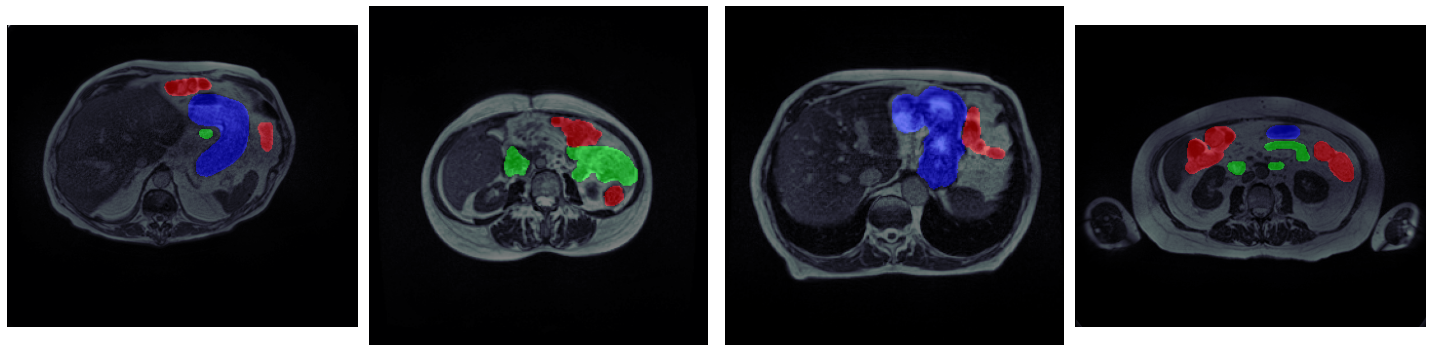

In [21]:
row=1; col=4
plt.figure(figsize=(5*col,5*row))
for i, id_ in enumerate(train_df[~train_df.segmentation.isna()].sample(frac=1.0)['id'].unique()[:row*col]):
    img = load_img(train_df[train_df['id']==id_].image_path.iloc[0])
    mask = id2mask(train_df,id_)*255
    plt.subplot(row, col, i+1)
    i+=1
    show_img(img, mask=mask)
    plt.tight_layout()